In [1]:
import pandas as pd
import numpy as np

# 学生知识掌握成都分类 KNN-分类
Knowledge = pd.read_excel(r'Knowledge.xlsx')
# STG:目标科目学习时长， SCG:重复次数， STR:相关科目学习时长， 
# LPR：相关科目考试成绩， PEG：目标科目考试成绩， UNS：掌握成都
Knowledge.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,Very Low
1,0.08,0.08,0.10,0.24,0.90,High
2,0.06,0.06,0.05,0.25,0.33,Low
3,0.10,0.10,0.15,0.65,0.30,Middle
4,0.08,0.08,0.08,0.98,0.24,Low


In [2]:
# test data
from sklearn import model_selection

predictors = Knowledge.columns[:-1]
X_train, X_test, y_train, y_test = model_selection.train_test_split(Knowledge[predictors], Knowledge.UNS, 
                                                                    test_size = 0.25, random_state = 1234)

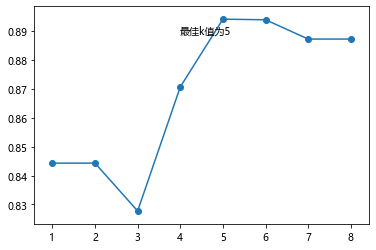

In [4]:
from sklearn import neighbors
import matplotlib.pyplot as plt

#测试K值设定
K = np.arange(1,np.ceil(np.log2(Knowledge.shape[0])))
accuracy = []
for k in K:
    cv_result = model_selection.cross_val_score(neighbors.KNeighborsClassifier(n_neighbors = int(k), weights = 'distance'), 
                                                X_train, y_train, cv = 10, scoring='accuracy')
    accuracy.append(cv_result.mean())
arg_max = np.array(accuracy).argmax()
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(K, accuracy)
plt.scatter(K, accuracy)
plt.text(K[arg_max]-1, accuracy[arg_max]-0.005, '最佳k值为%s' %int(K[arg_max]))
plt.show()

In [5]:
# knn model
from sklearn import metrics

knn_class = neighbors.KNeighborsClassifier(n_neighbors = 6, weights = 'distance')
knn_class.fit(X_train, y_train)
predict = knn_class.predict(X_test)
cm = pd.crosstab(predict,y_test)
cm

UNS,High,Low,Middle,Very Low
row_0,,,,
High,29,0,0,0
Low,0,34,3,5
Middle,1,0,23,0
Very Low,0,0,0,6


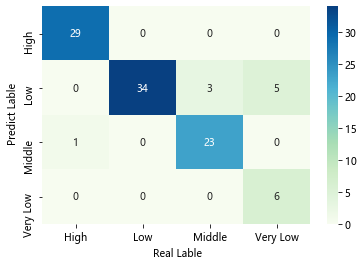

In [6]:
# sns show
import seaborn as sns

cm = pd.DataFrame(cm)
sns.heatmap(cm, annot = True,cmap = 'GnBu')
plt.xlabel(' Real Lable')
plt.ylabel(' Predict Lable')
plt.show()

In [7]:
# 预测准确率
print(metrics.accuracy_score(y_test, predict))
#评估报告
print(metrics.classification_report(y_test, predict))

0.9108910891089109
              precision    recall  f1-score   support

        High       1.00      0.97      0.98        30
         Low       0.81      1.00      0.89        34
      Middle       0.96      0.88      0.92        26
    Very Low       1.00      0.55      0.71        11

    accuracy                           0.91       101
   macro avg       0.94      0.85      0.88       101
weighted avg       0.93      0.91      0.91       101



In [8]:
# 高炉煤气发电 KNN-回归
ccpp = pd.read_excel(r'CCPP.xlsx')
# AT:高炉温度， V:炉内压力， AP:高炉湿度， RH:高炉排气量， PE:高炉发电量
display(ccpp.head())
ccpp.shape

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


(9568, 5)

In [9]:
from sklearn.preprocessing import minmax_scale

# 数据标准化处理
predictors = ccpp.columns[:-1]
X = minmax_scale(ccpp[predictors])
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, ccpp.PE, 
                                                                    test_size = 0.25, random_state = 1234)

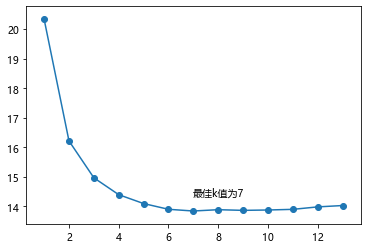

In [10]:
# 绘图
K = np.arange(1,np.ceil(np.log2(ccpp.shape[0])))
# 存储平均MSE
mse = []
for k in K:
    cv_result = model_selection.cross_val_score(neighbors.KNeighborsRegressor(n_neighbors = int(k), weights = 'distance'), 
                                                X_train, y_train, cv = 10, scoring='neg_mean_squared_error')
    mse.append((-1*cv_result).mean())

arg_min = np.array(mse).argmin()
plt.plot(K, mse)
plt.scatter(K, mse)
plt.text(K[arg_min], mse[arg_min] + 0.5, '最佳k值为%s' %int(K[arg_min]))
plt.show()

In [11]:
# 最佳重新构建模型
knn_reg = neighbors.KNeighborsRegressor(n_neighbors = 7, weights = 'distance')
knn_reg.fit(X_train, y_train)
predict = knn_reg.predict(X_test)
metrics.mean_squared_error(y_test, predict)

12.814094947334913

In [12]:
# 对比真实值和实际值
pd.DataFrame({'Real':y_test,'Predict':predict}, columns=['Real','Predict']).head(5)

,Real,Predict
2620,435.68,437.677598
6998,442.90,443.101594
2857,449.01,448.758681
6510,449.75,445.560046
5368,455.20,453.010541


In [13]:
# 与决策树对比
from sklearn import tree

max_depth = [19,21,23,25,27]
min_samples_split = [2,4,6,8]
min_samples_leaf = [2,4,8,10,12]
parameters = {'max_depth':max_depth, 'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf}
# 网格搜索
grid_dtreg = model_selection.GridSearchCV(estimator = tree.DecisionTreeRegressor(), param_grid = parameters, cv=10)
grid_dtreg.fit(X_train, y_train)
grid_dtreg.best_params_

{'max_depth': 25, 'min_samples_leaf': 10, 'min_samples_split': 6}

In [14]:
CART_Reg = tree.DecisionTreeRegressor(max_depth = grid_dtreg.best_params_["max_depth"], 
                                      min_samples_leaf = grid_dtreg.best_params_["min_samples_leaf"], 
                                      min_samples_split = grid_dtreg.best_params_["min_samples_split"])
CART_Reg.fit(X_train, y_train)
pred = CART_Reg.predict(X_test)
metrics.mean_squared_error(y_test, pred)

16.17598770280405